The `Planetoid` dataset class is specifically designed to load and manage several popular benchmark datasets for node classification on citation networks.

Citation networks are graph-structured datasets where nodes represent documents (e.g., scientific papers) and edges represent citation relationships between documents. The task in node classification on citation networks is to predict the category or class of each document based on its content and citation relationships.

The `Planetoid` class in PyTorch Geometric provides access to the following citation network datasets:

- **Cora**: The Cora dataset consists of scientific papers, where nodes represent documents, and edges represent citation relationships. Each paper is categorized into one of several research fields.

- **CiteSeer**: Similar to Cora, the CiteSeer dataset contains scientific papers and citation relationships. Papers are categorized into research fields.

- **PubMed**: The PubMed dataset is also a citation network but focused on biomedical literature. It includes articles and their citation relationships, with documents categorized into biomedical topics.

These datasets are commonly used as benchmarks for evaluating the performance of GNNs and other graph-based machine learning models on node classification tasks.

The **Cora** dataset includes "bag-of-words" (BoW) representations as node features.

In the Cora dataset loaded in this notebook:

- Each node in the graph represents a scientific paper.
- The node features represent the content of these papers.
- These content features are represented as a bag-of-words (BoW). Each element in the BoW vector represents the presence (1) or absence (0) of a specific word in the paper. After normalization, 1 will be changed to its proportion.

In [1]:
import collections
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_networkx

In [2]:
def visualize_graph(G, color):
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="tab10", node_size=5)

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=50, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Acc: {accuracy: .3f}', fontsize=16)

In [3]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [4]:
!ls data/Planetoid/Cora/

processed raw


In [5]:
print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [6]:
data = dataset[0]
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges/data.num_nodes}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Proportion of labeled (training) nodes: {int(data.train_mask.sum()) / data.num_nodes: .2f}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.8980797636632203
Number of training nodes: 140
Proportion of labeled (training) nodes:  0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [7]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
def inspect_label_count(data, mask_type):
    if mask_type == "train":
        labels = data.y[data.train_mask]
    elif mask_type == "val":
        labels = data.y[data.val_mask]
    else:
        labels = data.y[data.test_mask]
    counts = collections.Counter(labels.detach().numpy())
    total = len(labels)
    return(total, counts)

total, counts = inspect_label_count(data, "train")
print(total)
print(counts)

140
Counter({3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20})


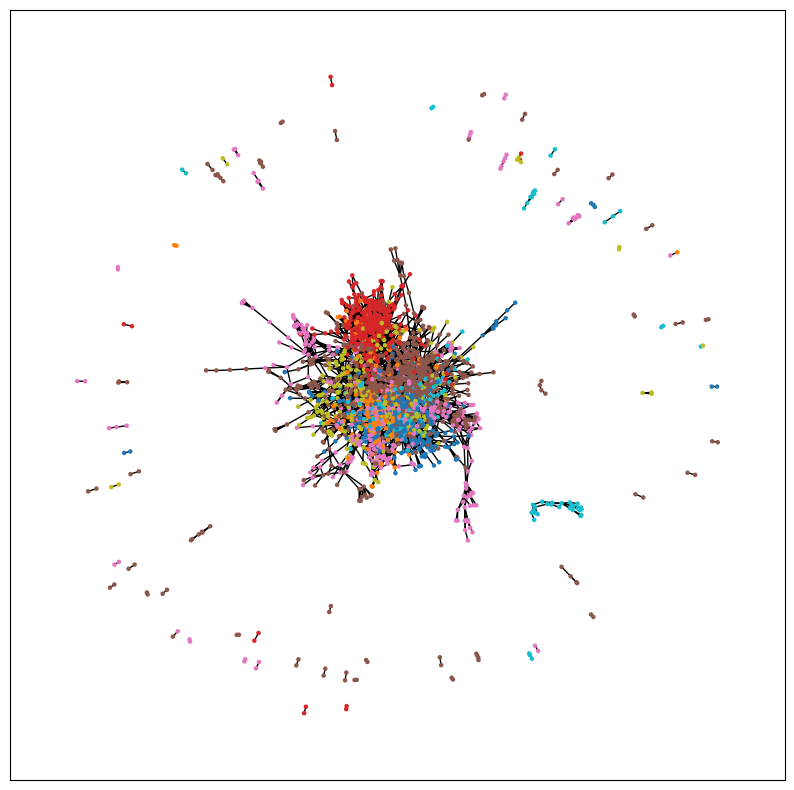

In [9]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

## Multi-layer Perceptron Network (MLP)
Let's classify solely based on the bag-of-words feature representation without taking into account the graph's structural information. 

Our MLP is defined by two linear layers with [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_size=16`), while the second linear layer maps each low-dimensional node embedding to one of the 7 classes.

Because the model has a dropout layer which behaves differently during training and validation, we need to be careful and use `model.train()` and `model.eval()` in the correct places.

The `torch.nn.CrossEntropyLoss` function is designed to work with predicted logits and class labels, and it automatically applies the softmax function to the logits internally before computing the loss.

In [10]:
feature_size = data.num_features
hidden_size = 16
num_classes = dataset.num_classes

class MLP(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(feature_size, hidden_size)
        self.lin2 = Linear(hidden_size, num_classes)
    def forward(self, x):
        h = self.lin1(x)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        logits = self.lin2(h)
        return logits

model = MLP(hidden_size)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    logits = model(data.x)
    loss = criterion(logits[data.train_mask], data.y[data.train_mask])
    train_pred = logits[data.train_mask].argmax(dim=1)
    train_correct =  train_pred == data.y[data.train_mask]
    train_accuracy = int(train_correct.sum()) / int(data.train_mask.sum())
    loss.backward()
    optimizer.step()
    return float(loss), train_accuracy

def test():
    model.eval()
    logits = model(data.x)
    test_loss = criterion(logits[data.test_mask], data.y[data.test_mask])
    y_pred = logits[data.test_mask].argmax(dim=1)
    test_correct = y_pred == data.y[data.test_mask]
    test_accuracy = int(test_correct.sum())/ int(data.test_mask.sum())
    return float(test_loss), test_accuracy
    

In [12]:
for epoch in range(1, 201):
    loss, accuracy = train()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {accuracy:.3f}")

Epoch: 010, Loss: 1.8849, Acc: 0.386
Epoch: 020, Loss: 1.7383, Acc: 0.714
Epoch: 030, Loss: 1.5396, Acc: 0.750
Epoch: 040, Loss: 1.3391, Acc: 0.771
Epoch: 050, Loss: 1.1060, Acc: 0.829
Epoch: 060, Loss: 0.9173, Acc: 0.829
Epoch: 070, Loss: 0.7889, Acc: 0.850
Epoch: 080, Loss: 0.6899, Acc: 0.886
Epoch: 090, Loss: 0.6685, Acc: 0.864
Epoch: 100, Loss: 0.6106, Acc: 0.857
Epoch: 110, Loss: 0.5888, Acc: 0.893
Epoch: 120, Loss: 0.5277, Acc: 0.886
Epoch: 130, Loss: 0.5053, Acc: 0.907
Epoch: 140, Loss: 0.5623, Acc: 0.864
Epoch: 150, Loss: 0.4934, Acc: 0.893
Epoch: 160, Loss: 0.4170, Acc: 0.929
Epoch: 170, Loss: 0.4678, Acc: 0.907
Epoch: 180, Loss: 0.4808, Acc: 0.871
Epoch: 190, Loss: 0.4602, Acc: 0.893
Epoch: 200, Loss: 0.4827, Acc: 0.900


In [13]:
test_loss, accuracy_loss = test()

In [14]:
print(f"Test Loss: {test_loss:.4f}, Test Acc: {accuracy_loss:.3f}")

Test Loss: 1.2899, Test Acc: 0.574
